## Functions for sampling

In [1]:
import math
import numpy as np
import pandas as pd
import anndata
import scipy
import numba as nb
import scanpy as sc
import os
from typing import Optional
import muon as mu


/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def conway_maxwell_poisson(lambda_, nu):
    """ Sample from the Conway-Maxwell-Poisson distribution. """
    # Calculate normalizing constant
    C = np.sum([(pow(lambda_, k) / math.factorial(k)) ** nu for k in range(1000)])
    
    # Sample from the distribution
    u, sum_p, k = np.random.rand(), 0, 0
    while sum_p < u:
        sum_p += (pow(lambda_, k) / math.factorial(k)) ** nu / C
        k += 1
    return k - 1

def sample_cell(params, cluster_p, clusters, sc_rna_celltypes, sample_exp, sample_cluster, cell_p_balanced):

    exp = {key: np.zeros((len(params), data.X.shape[1])) for key, data in sample_exp.items()}
    density = np.zeros((len(params), len(clusters)))
    
    for i in nb.prange(len(params)):
        num_cell, num_cluster = params[i]
        used_clusters = clusters[np.searchsorted(np.cumsum(cluster_p), np.random.rand(num_cluster), side="right")]
        cluster_mask = np.isin(sc_rna_celltypes, used_clusters)
        
        used_cell_ind = np.where(cluster_mask)[0]

        used_cell_p = cell_p_balanced[cluster_mask] / cell_p_balanced[cluster_mask].sum()

        sampled_cells = used_cell_ind[np.searchsorted(np.cumsum(used_cell_p), np.random.rand(num_cell), side="right")]
        
        for key, data in sample_exp.items():
            exp[key][i, :] = sample_exp[key][sampled_cells, :].X.sum(axis=0)
        density[i, :] = sample_cluster[sc_rna_celltypes[sampled_cells]].sum(axis=0)

    return exp, density

class Sampler:
    def __init__(self, mdata, celltype_key, cell_number_mean=6, cell_number_nu=20, celltype_number_mean=4, celltype_number_nu=0.5):
        self.mdata = mdata
        self.adata = mdata['rna']
        self.cell_number_mean = cell_number_mean
        self.cell_number_nu = cell_number_nu
        self.celltype_number_mean = celltype_number_mean
        self.celltype_number_nu = celltype_number_nu

        self.sample_exp = mdata.mod
        self.init_sample_prob(celltype_key)
        
        self.clusters = self.adata.uns['cluster_p_sqrt'].index.values.astype(int)
        self.sample_cluster = np.eye(len(self.clusters))
        self.sc_rna_celltypes = self.adata.obs['celltype_num'].values.astype(int)

        
    def init_sample_prob(self, celltype_key):
        celltype2num = dict(enumerate(self.adata.obs[celltype_key].unique()))
        self.adata.obs['celltype_num'] = self.adata.obs[celltype_key].replace({v: k for k, v in celltype2num.items()})
        
        
        cell_counts = self.adata.obs['celltype_num'].value_counts(normalize=True)
        self.adata.uns['cluster_p_unbalance'] = cell_counts
        self.adata.uns['cluster_p_sqrt'] = np.sqrt(cell_counts) / np.sqrt(cell_counts).sum()
        self.adata.uns['cluster_p_balance'] = 1 / len(cell_counts)
       
        self.adata.obs['cell_p_balanced'] = 1 / self.adata.obs['celltype_num'].replace(cell_counts).astype(float)


    def sample_data(self, num_sample, balance=None):
        if balance is None:
            cluster_p = self.adata.uns['cluster_p_unbalance'].values
        elif balance == 'balance':
            cluster_p = np.repeat(self.adata.uns['cluster_p_balance'], len(self.clusters))
        elif balance == 'sqrt':
            cluster_p = self.adata.uns['cluster_p_sqrt'].values
        else:
            raise ValueError('balance must be one of [None, "balance", "sqrt"].')
        
        cell_count = np.array([conway_maxwell_poisson(self.cell_number_mean, self.cell_number_nu) for _ in range(num_sample)])
        cell_count[cell_count == 0] = 1
        colocated_count = np.array([conway_maxwell_poisson(self.celltype_number_mean, self.celltype_number_nu) for _ in range(num_sample)])
        colocated_count[colocated_count == 0] = 1
        params = np.vstack([cell_count, colocated_count]).T
        return sample_cell(params, cluster_p, self.clusters, self.sc_rna_celltypes, self.sample_exp, self.sample_cluster, self.adata.obs['cell_p_balanced'].values)


def generate_spatial_data(
    mdata: mu.MuData, 
    celltype_key: str, 
    save_path: Optional[str] = None,
    downsample_frac: Optional[float] = None,
    size: int = 1000,
    n_col: int = 40,
    balance: Optional[str] = None,
    **kwargs
) -> anndata.AnnData:
    """
    Generate spatial data.

    Returns:
        anndata.AnnData: Generated spatial data.
    """
    
    np.random.seed(0)
    sampler = Sampler(
        mdata, celltype_key, **kwargs
    )
    
    exp, density = sampler.sample_data(size, balance=balance)
    
    spatial_mod = {}

    # Define spots on a grid
    n_row = size // n_col
    coords = np.array([
        [10 * x, 10 * y]
        for y in range(n_row)
        for x in range(n_col)
    ])

    for key, data in exp.items():
        spatial_ann = anndata.AnnData(scipy.sparse.csr_matrix(data))
        spatial_ann.var.index = mdata[key].var_names
        spatial_ann.obs['cell_count'] = density.sum(axis=1)
        spatial_ann.uns['density'] = pd.DataFrame(density, columns=mdata['rna'].obs[celltype_key].unique(), index=spatial_ann.obs_names)
        spatial_ann.obsm['proportions'] = density / density.sum(axis=1)[:, None]
        spatial_ann.uns['proportion_names'] = mdata['rna'].obs[celltype_key].unique().tolist()
        spatial_ann.obsm['spatial'] = coords.astype('int')

        spatial_mod[key] = spatial_ann
    
    mdata_sp = mu.MuData(spatial_mod)
    
    if save_path:
        mdata_sp.write(os.path.join(save_path))
    
    return mdata_sp


In [3]:
4

4

In [4]:
import matplotlib.pyplot as plt
def plot_mean_variance(adata, layer=None, n_regions=10000, log=True):
    # Calculate mean and variance
    # sample regions
    regions = adata.var_names.to_series().sample(n_regions)

    matrix = adata[:, regions].X.A if layer is None else adata[:, regions].layers[layer]
    mean = np.mean(matrix, axis=0).squeeze()
    var = np.var(matrix, axis=0).squeeze()

    if log:
        mean = np.log10(mean)
        var = np.log10(var)
    plt.scatter(mean, var)
    plt.axline((0,0), slope=1, color='gray')

## Load the data

In [5]:
# Load Llorens data
mdata = mu.read('/vol/storage/data/cellxgene/human_cardiac_niches/human_cardiac_niches.h5mu')


In [6]:
mdata

MuData object with n_obs × n_vars = 139835 × 462560
  var:	'highly_variable'
  2 modalities
    atac:	139835 x 429828
      obs:	'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'batch_key', 'cell_type', 'cell_state'
      var:	'highly_variable'
      layers:	'tfidf_normalized'
    rna:	139835 x 32732
      obs:	'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
      var:	'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_type_colors', 'facility_colors', 'flushed_colors', 'gender_colors', 'hvg', 'kit_10x_colors', 'leiden', 'log1p', 'modality_colors', 'neighbors', 'original_or_new_colors', 'region_colors', 'region_finest_colors', 'scANVI_predictions_colors', 'umap'
      obsm:	'X_scArches', 'X_umap'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

In [7]:
# Move counts to X

In [8]:
mdata['rna'].X = mdata['rna'].layers['counts'].copy()

In [9]:
mdata['atac'].X.sum()

985354430.0

In [10]:
downsample_frac = 0.5

In [11]:
sc.pp.downsample_counts(mdata['rna'], counts_per_cell= (mdata['rna'].X.sum(axis=1).A * downsample_frac).astype(int).squeeze())

In [12]:
sc.pp.downsample_counts(mdata['atac'], counts_per_cell= (mdata['atac'].X.sum(axis=1).A * downsample_frac).astype(int).squeeze())

In [13]:
mdata['atac'].X.sum()

492642300.0

## Simulate spatial data

In [27]:
test = pd.Series([conway_maxwell_poisson(4, 5) for _ in range(1000)])

<Axes: ylabel='Frequency'>

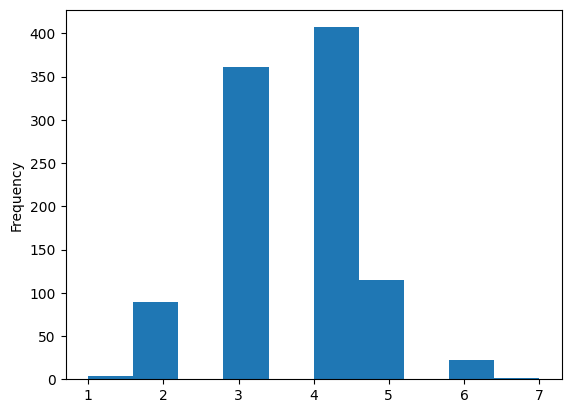

In [28]:
test.plot(kind='hist')

In [40]:
for means in [5, 15, 20]:
    print(means)
    mdata_sp = generate_spatial_data(
        mdata, 
        celltype_key='cell_type', 
        save_path=f'/vol/storage/data/simulations/human_cardiac_niches_simulation_mean_{means}.h5mu',
        cell_number_mean=means,
        cell_number_nu=20,
        celltype_number_mean=4,
        celltype_number_nu=5,
        downsample_frac=0.1,
        balance='balance'
    )


5


/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


15


/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


20


/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [41]:
mdata_sp

MuData object with n_obs × n_vars = 1000 × 462560
  2 modalities
    atac:	1000 x 429828
      obs:	'cell_count'
      uns:	'density', 'proportion_names'
      obsm:	'proportions', 'spatial'
    rna:	1000 x 32732
      obs:	'cell_count'
      uns:	'density', 'proportion_names'
      obsm:	'proportions', 'spatial'

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_549538/1867623691.py:12: RuntimeWarning: divide by zero encountered in log10
  mean = np.log10(mean)
/tmp/ipykernel_549538/1867623691.py:13: RuntimeWarning: divide by zero encountered in log10
  var = np.log10(var)


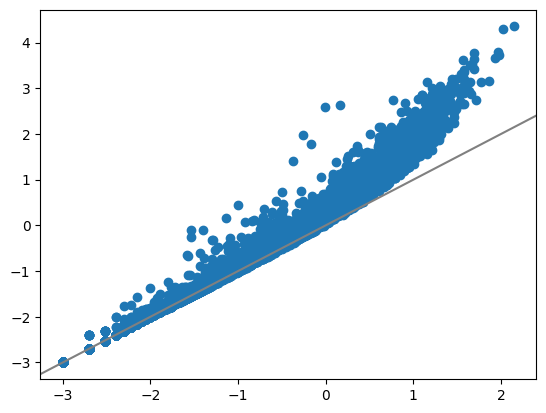

In [42]:
plot_mean_variance(mdata_sp['rna'])

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


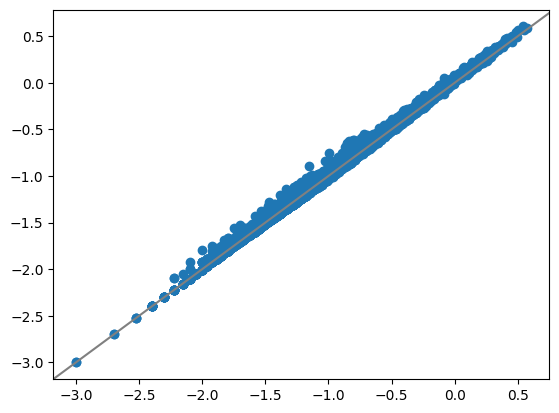

In [43]:
plot_mean_variance(mdata_sp['atac'])

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


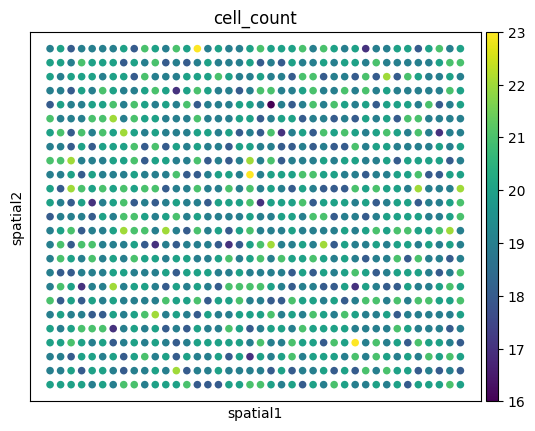

In [44]:
sc.pl.embedding(mdata_sp['atac'], basis='spatial', color='cell_count')

In [34]:
import matplotlib.pyplot as plt

# Now we will create a function to plot pie charts at specified coordinates
def plot_pie_charts(spots_data, x_coords, y_coords):
    # Assuming we have equal numbers of spots and coordinates
    assert len(spots_data) == len(x_coords) == len(y_coords)
    
    fig, ax = plt.subplots()
    
    # Size of the entire plotting area
    ax.set_xlim(min(x_coords) - 4, max(x_coords) + 4)
    ax.set_ylim(min(y_coords) - 4, max(y_coords) + 4)
    
    # Creating a pie chart for each spot
    for data, x, y in zip(spots_data, x_coords, y_coords):
        #sizes = list(data.values())
        #labels = list(data.keys())
        ax.pie(data, labels=None, radius=4, center=(x, y), colors=mdata['rna'].uns['cell_type_colors'])
    
    return ax


/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


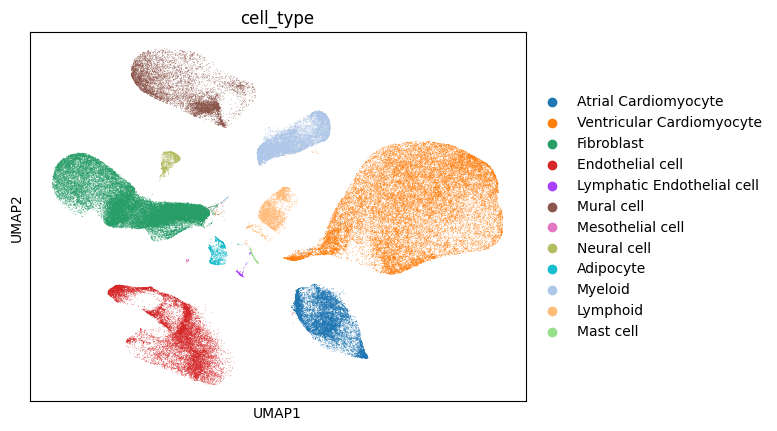

In [35]:
sc.pl.umap(mdata['rna'], color='cell_type')

In [45]:
proportions = pd.DataFrame(mdata_sp['rna'].obsm['proportions'], columns=mdata_sp['rna'].uns['proportion_names']).loc[:, mdata['rna'].obs.cell_type.cat.categories]

In [46]:
(proportions > 0).sum(axis=0).value_counts()

261    2
297    1
263    1
292    1
253    1
262    1
255    1
284    1
243    1
272    1
276    1
Name: count, dtype: int64

In [47]:
mdata_sp['rna'].obs.cell_count.value_counts()

cell_count
19.0    367
20.0    317
21.0    151
18.0    133
22.0     16
17.0     12
23.0      3
16.0      1
Name: count, dtype: int64

In [48]:
ax = plot_pie_charts(proportions.values[:80], mdata_sp['rna'].obsm['spatial'][:, 0][:80], mdata_sp['rna'].obsm['spatial'][:, 1][:80])
plt.show()

: 